In [ ]:
!pip install nltk==3.5

In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# change here to your dataset path
import sklearn

# PATH = 'IMDB Dataset.csv'
PATH = '/content/drive/MyDrive/imdb/IMDB Dataset.csv'

## **1. Background**

![Natural language processing](https://landbot.io/wp-content/uploads/2019/11/natural-language-processing-chatbot.jpg)

**What is Natural Language Processing?**

From wikipedia, Natural language processing (NLP) is a subfield of linguistics, computer science, information engineering, and artificial intelligence concerned with the interactions between computers and human (natural) languages, in particular how to program computers to process and analyze large amounts of natural language data.

**What is Sentiment Classification?**

Sentiment analysis (also known as opinion mining or emotion AI) refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.

**What is Tokenizer?**

Tokenization is a necessary first step in many natural language processing tasks, such as word counting, parsing, spell checking, corpus generation, and statistical analysis of text.

Tokenizer is a compact pure-Python (2 and 3) executable program and module for tokenizing Icelandic text. It converts input text to streams of tokens, where each token is a separate word, punctuation sign, number/amount, date, e-mail, URL/URI, etc. It also segments the token stream into sentences, considering corner cases such as abbreviations and dates in the middle of sentences.[Tokenizer](https://pypi.org/project/tokenizer/)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Serfati/imdb_sentiment_analysis)

In [3]:
# !pip install -r requirements.txt
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter

In [5]:
import re
import os
import pandas as pd
import numpy as np

In [6]:
# visualization
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [7]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

## **2. Data exploratory analysis**


### **2.1 Data overview**

![IMDB 50 review datasets](https://o.aolcdn.com/images/dims?quality=85&image_uri=https%3A%2F%2Fo.aolcdn.com%2Fimages%2Fdims%3Fcrop%3D908%252C537%252C0%252C0%26quality%3D85%26format%3Djpg%26resize%3D1600%252C947%26image_uri%3Dhttps%253A%252F%252Fs.yimg.com%252Fos%252Fcreatr-uploaded-images%252F2019-08%252F560e5d20-c833-11e9-bf26-36635805fe83%26client%3Da1acac3e1b3290917d92%26signature%3D639a4965c41ca6cec13652498f65cfc97170ea5d&client=amp-blogside-v2&signature=765e155477177a69b93eac5611145d4241be6071)

This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.

**Dataset**

The core dataset contains 50,000 reviews. The overall distribution of labels is balanced (25k pos and 25k neg). We also include an additional 50,000 unlabeled documents for unsupervised learning.

### **2.2 Data Exploration**

The first step is to load the data to global environment.

In [9]:
df = pd.read_csv(PATH)

We could see some abnormal words such as <br /><br />, then we should replace them by a null or space value.

Text(0.5, 1.0, 'Words occurrence frequency')

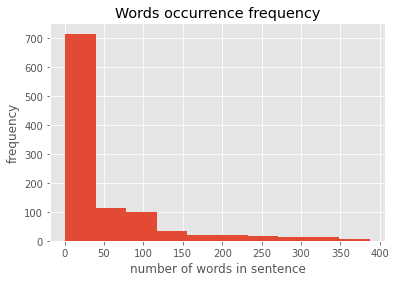

In [10]:
plt.figure()
plt.hist(df['review'].str.split().apply(len).value_counts())
plt.xlabel('number of words in sentence')
plt.ylabel('frequency')
plt.title('Words occurrence frequency')

In [11]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [13]:
df["review"][0][:250]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of "

In [14]:
df["sentiment"][0]

'positive'

In [15]:
df["review"].groupby(df["sentiment"]).count()

sentiment
negative    25000
positive    25000
Name: review, dtype: int64

Text(0.5, 1.0, 'Reviews polarity')

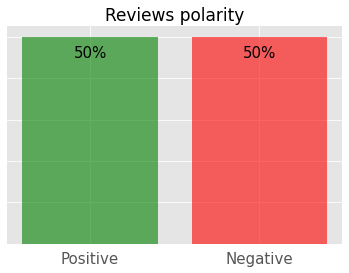

In [16]:
# Sentiment reviews distribution
s = df['sentiment'].value_counts()
s = (s/s.sum())*100

plt.figure()
bars = plt.bar(s.index, s.values, color = ['green', 'red'], alpha = .6)
plt.xticks(s.index, ['Positive', 'Negative'], fontsize = 15)
plt.tick_params(bottom = False, top = False, left = False, right = False, labelleft = False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 5, s = str(bar.get_height())[:2] + '%', ha = 'center', fontsize = 15)
plt.title('Reviews polarity', fontsize = 17)

### **2.3 Data pre-processing**

**Text Cleaning**

0.Label Encoder

1.Remove html tags

2.Remove special characters

3.Converting every thing to lower case

4.Removing Stop words

5.Stemming

6.Remove extra spaces

7.Lemmatization

In [17]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [18]:
df['review'] = df['review'].str.replace('<br />','')

In [19]:
# function to remove special characters
df["review"] = df["review"].apply(lambda x: re.sub("[^0-9a-zA-Z]",' ', x))

In [20]:
df['review'] = df['review'].str.lower()

In [21]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to C:\Users\Liron
[nltk_data]     Simhon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Stop Words Removal**

We'll remove the stop words for better prediction.

In [22]:
from tqdm import tqdm
nltk.download('punkt')
pbar = tqdm(total=df.shape[0], leave=True, position=0)

def remove_sw(review):
    tokens = word_tokenize(review)
    tokens = [w for w in tokens if not w in stop_words]
    pbar.update(1)
    return " ".join(tokens)

df["review"] = df["review"].apply(remove_sw)
pbar.close()

[nltk_data] Downloading package punkt to C:\Users\Liron
[nltk_data]     Simhon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 50000/50000 [01:04<00:00, 773.34it/s]


**Porter Stemmer**

For this particular dataset the PorterStemmer does not bring better performance, so it is better to skip this step.

In [23]:
pbar = tqdm(total=df.shape[0], leave=True, position=0)
ps = PorterStemmer()

def stem(text):
    pbar.update(1)
    return ' '.join([ps.stem(word) for word in text.split()])

df["review"] = df["review"].apply(stem)
pbar.close()

100%|██████████| 50000/50000 [03:15<00:00, 255.55it/s]


In [24]:
nltk.download('punkt')
#Creating a Lemmatizer for preprocessing
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

[nltk_data] Downloading package punkt to C:\Users\Liron
[nltk_data]     Simhon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
df["review"] = df["review"].apply(lambda x: re.sub(" +"," ", x))

In [26]:
# A cleaned review after pre proccessing
df['review'][0]

'one review mention watch 1 oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch darker side'

In [27]:
neg = df[df['sentiment'] == 0]
pos = df[df['sentiment'] == 1]

In [28]:
import plotly.express as px
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [29]:
# Unigram - Commmon Words in Negative Text
most_common_uni = get_top_text_ngrams(neg.review,10,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Unigram - Commmon Words in Negative Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()


In [30]:
# Unigram - Commmon Words in Positive Text
most_common_uni = get_top_text_ngrams(pos.review,10,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Unigram - Commmon Words in Positive Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [31]:
# Bigram - Commmon Words in Negative Text
most_common_uni = get_top_text_ngrams(neg.review,10,2)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Bigram - Commmon Words in Negative Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [32]:
# Bigram - Commmon Words in Positive Text
most_common_uni = get_top_text_ngrams(pos.review,10,2)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Bigram - Commmon Words in Positive Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [33]:
X = df['review']
y = df['sentiment']

Split data to train and test for modeling and performance evaluation.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

print('Training dataset : {} reviews'.format(X_train.shape[0]))
print('Testing dataset : {} reviews'.format(X_test.shape[0]))

Training dataset : 25000 reviews
Testing dataset : 25000 reviews


In [35]:
y_test.value_counts()

1    12517
0    12483
Name: sentiment, dtype: int64

## 2. Unsupervised Learning Approach

In [36]:
import nltk
from nltk.corpus import sentiwordnet as swn
nltk.download('sentiwordnet')

def calc_review_sentiment(review):
    sentences = nltk.sent_tokenize(review)
    stokens = [nltk.word_tokenize(sent) for sent in sentences]
    taggedlist=[]

    #stoken: tokens for one sentence. Create POS tagging for each token
    for stoken in stokens:
         taggedlist.append(nltk.pos_tag(stoken))
    wnl = nltk.WordNetLemmatizer()

    score_list=[]
    for idx,taggedsent in enumerate(taggedlist):  #iterate over all tokens
        score_list.append([])
        for idx2,t in enumerate(taggedsent):  #t[0] word, t[1] pos tag
            newtag=''
            lemmatized=wnl.lemmatize(t[0])
            if t[1].startswith('NN'):
                newtag='n'
            elif t[1].startswith('JJ'):
                newtag='a'
            elif t[1].startswith('V'):
                newtag='v'
            elif t[1].startswith('R'):
                newtag='r'
            else:
                newtag=''
            if(newtag!=''):
                synsets = list(swn.senti_synsets(lemmatized, newtag))
                #synsets contains for each token the probability for negative, positive and objective
                #Getting average of all possible sentiments, as you requested
                score=0
                if(len(synsets)>0):
                    for syn in synsets:
                        score+=syn.pos_score()-syn.neg_score()
                    score_list[idx].append(score/len(synsets))

    sentence_sentiment=[]

    for score_sent in score_list:
        sentence_sentiment.append(sum([word_score for word_score in score_sent])/len(score_sent))

    return sentence_sentiment[0]

def calc_accuracy(preds, reals):
    hits = 0
    for pred, real in zip(preds, reals):
        if pred > 0 and real == 1:
            hits += 1
        elif pred < 0 and real == 0:
            hits += 1

    total = len(reals)
    return hits / total

scores = X_test.apply(lambda review: calc_review_sentiment(review))
accuracy = calc_accuracy(scores, y_test)
print(accuracy)


[nltk_data] Downloading package sentiwordnet to C:\Users\Liron
[nltk_data]     Simhon\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


We have obtained more than 63% accuracy in predicting whether the review message is positive or negative, and we have performed feature extraction from the raw text in the process.

## **3. Modeling**

### 3.1 Feature Extraction using TF-IDF algorithm

![TFIDF](https://miro.medium.com/max/532/0*bHkPdhgfnyTs4un_)

In scikit-learn, the TF-IDF algorithm is implemented using **TfidfTransformer**. This transformer needs the count matrix which it will transform later. Hence, we use **CountVectorizer** first.
Alternatively, one can use **TfidfVectorizer**, which is the equivalent of CountVectorizer followed by TfidfTransformer

In [37]:
nltk.download('wordnet')

# default max_df = 0.5
def create_tfidfVect(max_df):
    tfidfVect = TfidfVectorizer( max_df = max_df,
                                sublinear_tf=True,
                                lowercase = True, 
                                ngram_range = (1,2), 
                                tokenizer = LemmaTokenizer(),
                                stop_words = 'english',
                                min_df = 1,
                                use_idf = True,
                                # max_features = 1000,
                                strip_accents = 'ascii'
                                )
    return tfidfVect

[nltk_data] Downloading package wordnet to C:\Users\Liron
[nltk_data]     Simhon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
tfidfVect = create_tfidfVect(0.5)
%time features = tfidfVect.fit_transform(X_train)
features.shape

c:\users\liron simhon\venv\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 53.3 s


(25000, 1517681)

## Supervised Learning Approach

In [39]:
def print_accuracy_metrics(model, feature_ext, preds):
    print("Testing report of tuned " + model + " using " + feature_ext + ":")
    print(classification_report(y_test, preds))

    print("confusion matrix of " + model + " using " + feature_ext + ":")
    print(confusion_matrix(y_test, preds))

    print("Accuracy of " + model + " using " + feature_ext + ": {0:.3f}%".format(accuracy_score(y_test, preds)*100))

    return

## TfIdfVectorizer Feature Extraction 
**Naive Bayes Classifier for Multinomial**

In [40]:
#instantiate the model (with the default parameters)
mnb = MultinomialNB()
#fit the model with data (occurs in-place)
mnb.fit(features, y_train)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#tune parameters - hyper parameter optimizer
nb_clf = Pipeline([('vect', TfidfVectorizer()),('clf', MultinomialNB())])
parameters =  {'vect__max_df': (0.2,0.5),'clf__alpha': (0.01,0.5)}
gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=1, cv=KFold(n_splits=10, shuffle=True, random_state=0))
gs_clf = gs_clf.fit(X_train,y_train)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)


Best score:  0.8847999999999999
Best params:  {'clf__tol': 0.0001, 'vect__max_df': 0.5}


**Perceptron Classifier**

In [ ]:
from sklearn.linear_model import Perceptron
#instantiate the model (with the default parameters)
prcpt = Perceptron()
#fit the model with data (occurs in-place)
prcpt.fit(features, y_train)
#tune parameters - hyper parameter optimizer
prcpt_clf = Pipeline([('vect', TfidfVectorizer()),('clf', Perceptron())])
parameters =  {'vect__max_df': (0.3,0.5),'clf__alpha': (0.001,0.7)}
gs_clf = GridSearchCV(prcpt_clf, parameters, n_jobs=1, cv=KFold(n_splits=10, shuffle=True, random_state=0))
gs_clf = gs_clf.fit(X_train,y_train)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
#instantiate the model (with the default parameters)
lr = LogisticRegression()

#fit the model with data (occurs in-place)
lr.fit(features, y_train)

#tune parameters - hyper parameter optimizer
lr_clf = Pipeline([('vect', TfidfVectorizer()),('clf', LogisticRegression())])
parameters =  {'vect__max_df': (0.1,0.5),'clf__tol': (0.0001,0.001)}
gs_clf_b = GridSearchCV(lr_clf, parameters, n_jobs=1, cv=KFold(n_splits=10, shuffle=True, random_state=0))
gs_clf_b = gs_clf_b.fit(X_train,y_train)
print('Best score: ',gs_clf_b.best_score_)
print('Best params: ',gs_clf_b.best_params_)


### Feature Extraction using Count Vectorizer

In [41]:
def create_count_vectorizer(max_df):
    cv=CountVectorizer( max_df = max_df,
                    lowercase = True,
                    ngram_range = (1,2),
                    tokenizer = LemmaTokenizer(),
                    stop_words = 'english',
                    min_df = 1,
                    )
    return cv

In [ ]:
cv = create_count_vectorizer(0.5)
%time bow_features = cv.fit_transform(X_train)
bow_features.shape

**MultinomialNB**

In [ ]:
#instantiate the model (with the default parameters)
mnb2 = MultinomialNB()

#fit the model with data (occurs in-place)
mnb2.fit(bow_features, y_train)

#tune parameters - hyper parameter optimizer
nb_clf = Pipeline([('vect', CountVectorizer()),('clf', MultinomialNB())])
parameters =  {'vect__max_df': (0.2,0.5),'clf__alpha': (0.01,0.3)}
gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=1, cv=KFold(n_splits=10, shuffle=True, random_state=0))
gs_clf = gs_clf.fit(X_train,y_train)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)


**LogisticRegression**

In [ ]:
#instantiate the model (with the default parameters)
lr2 = LogisticRegression()

#fit the model with data (occurs in-place)
lr2.fit(bow_features, y_train)

#tune parameters - hyper parameter optimizer
lr2_clf = Pipeline([('vect', CountVectorizer()),('clf', LogisticRegression())])
parameters =  {'vect__max_df': (0.3,0.5),'clf__tol': (0.0001,0.001)}
gs_clf = GridSearchCV(lr2_clf, parameters, n_jobs=1, cv=KFold(n_splits=10, shuffle=True, random_state=0))
gs_clf = gs_clf.fit(X_train,y_train)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)


**Perceptron Classifier**

In [ ]:
#instantiate the model (with the default parameters)
prcpt2 = Perceptron()

#fit the model with data (occurs in-place)
prcpt2.fit(bow_features, y_train)

#tune parameters - hyper parameter optimizer
prcpt2_clf = Pipeline([('vect', CountVectorizer()),('clf', Perceptron())])
parameters =  {'vect__max_df': (0.1,0.5),'clf__alpha': (0.003,0.2)}
gs_clf = GridSearchCV(prcpt2_clf, parameters, n_jobs=1, cv=KFold(n_splits=10, shuffle=True, random_state=0))
gs_clf = gs_clf.fit(X_train,y_train)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)


## Evaluation

We'll take the model with the highest training accuracy score and evaluate the test set with it. 
In our case the **LogisticRegression Classifier with TfidfVectorizer** provided us the highest score.

In [42]:
# features_test = tfidfVect.fit_transform(X_test)
pred = gs_clf_b.predict(X_test)
pred = pd.DataFrame(pred)

In [43]:
print("Test accuracy score of LogisticRegression using TfidfVectorizer: {0:.3f}%".format(accuracy_score(y_test, pred)*100))
print("Test AUC score of LogisticRegression using TfidfVectorizer: {0:.3f} %".format(roc_auc_score(y_test, pred)*100))
print_accuracy_metrics("LogisticRegression", "TfidfVectorizer", pred)

Test accuracy score of LogisticRegression using TfidfVectorizer: 88.900%
Test AUC score of LogisticRegression using TfidfVectorizer: 88.898 %
Training report of tuned LogisticRegression using TfidfVectorizer:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89     12483
           1       0.88      0.90      0.89     12517

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

confusion matrix of LogisticRegression using TfidfVectorizer:
[[10905  1578]
 [ 1197 11320]]
Accuracy of LogisticRegression using TfidfVectorizer: 88.900%
